In [122]:
from utils import create_df, compute_fingerprints, compute_descriptors, create_data, eval_metrics

In [123]:
import numpy as np
import pandas as pd
import numpy as np
import rdkit
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import train_test_split

In [124]:
# Bloack for auto loading of imports from outside scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Предсказание фазы:

In [ ]:
descriptors = [
    "NumHBD",                # Number of Hydrogen Bond Donors (rdMolDescriptors)
    "NumHeavyAtoms",         # Number of Heavy Atoms

    'MolWt',                 # Molecular Weight
    'LogP',                  # LogP (octanol-water partition coefficient)
    'TPSA',                  # Topological Polar Surface Area
    'NumRotatableBonds',     # Number of Rotatable Bonds
    'NumHDonors',            # Number of Hydrogen Bond Donors
    'NumHAcceptors',         # Number of Hydrogen Bond Acceptors
    'FractionCSP3',          # Fraction of sp3 Hybridized Carbons
    'NumAromaticRings',      # Number of Aromatic Rings
    'FractionRotatableBonds',# Fraction of Rotatable Bonds
    'NumHBD',               
    'NumHBA',                # Number of Hydrogen Bond Acceptors (rdMolDescriptors)
    'NumRings',              # Number of Rings
    'NumHeteroatoms',        # Number of Heteroatoms
    'Chi0v',                 # Chi Connectivity Index 0 (Valence)
    'Chi1v',                 # Chi Connectivity Index 1 (Valence)
    'Chi2v',                 # Chi Connectivity Index 2 (Valence)
]

data_path = "./data/medium_dataset_solid_liquid_with_T_melt_data"
columns = ['line_number', 'smiles', 'cas', 'label', 'T']

df = create_df(data_path, columns)
df['T'] = df['T'].replace('fail', np.nan).astype(float)

### Трейн для классификации - все у чего нет температуры, остальное - тест, чтобы можно было идею с расстоянием до плоскости использовать:

- Получается Morgan Fingerprints почти что бесполезные - случайный фактор будет лучше или нет

In [154]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "create_fingerprints": False
}

In [163]:
df_no_temp = df[df["T"].isna()]
df_temp = df[df["T"].notna()]
temp = df_temp["T"]

_, X_no_temp, labels_train = create_data(df_no_temp, **data_args)
_, X_temp, labels_test = create_data(df_temp, **data_args)

#### Catboost:

In [164]:
from catboost import CatBoostClassifier, CatBoostRegressor

##### Phase Classification:

In [176]:
model_args = {
    "iterations": 1000,
    "learning_rate": 0.01,
    "depth": 11,
    # "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 0.01
}

classifier = CatBoostClassifier(**model_args)
classifier.fit(X_no_temp, labels_train, eval_set=(X_temp, labels_test))

y_pred_at = classifier.predict(X_temp)

In [175]:
eval_metrics(labels_test, y_pred_at)

{'ACC': 0.895,
 'BAL-ACC': 0.906164622183105,
 'ROC-AUC': 0.9061646221831051,
 'R2': 0.46091644204851756}

#### Catboost Feature Importance:

In [177]:
phase_pred_importance = classifier.get_feature_importance()

phase_pred_importance = phase_pred_importance / phase_pred_importance.sum()

Text(0, 0.5, 'Feature Importance')

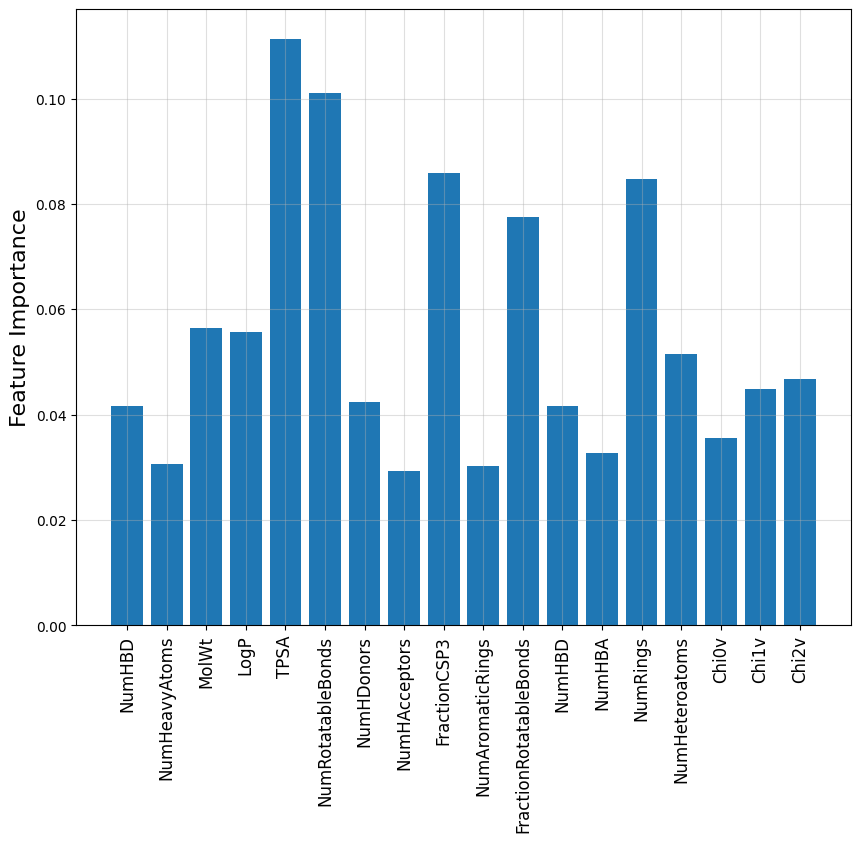

In [178]:
plt.figure(figsize=(10, 8))

plt.bar(range(len(phase_pred_importance)), phase_pred_importance, tick_label=descriptors)

plt.grid(alpha=0.4)
plt.xticks(rotation=90, fontsize=12)  # Rotate labels by 45 degrees
plt.ylabel("Feature Importance", fontsize=16)


---
## Temperature Regression:

### Only Molecular features:

In [191]:
model_args = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 7,
    # "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 1
}
TEST_SIZE = 0.4


temp_regressor = CatBoostRegressor(**model_args)

X_temp_train, X_temp_val, temp_train, temp_val = train_test_split(X_temp, temp, test_size=TEST_SIZE)

temp_regressor.fit(X_temp_train, temp_train, eval_set=(X_temp_val, temp_val))

temp_pred = temp_regressor.predict(X_temp_val)

In [193]:
eval_metrics(temp_pred, temp_val, type="regression")

{'MSE': 3732.663123576245,
 'RMSE': 61.09552457894314,
 'MAE': 42.59677869054369,
 'R2': 0.6034767061025439}

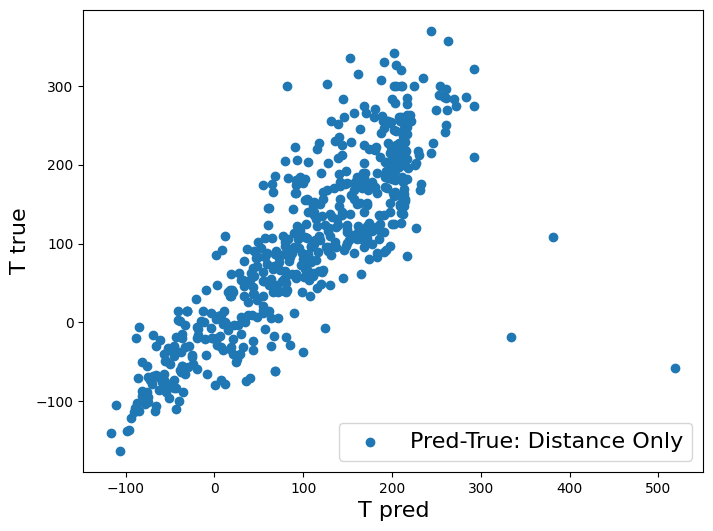

In [194]:
plt.figure(figsize=(8, 6))

plt.scatter(
    temp_pred, temp_val, label="Pred-True: Distance Only"
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

In [195]:
temp_regr_importance = temp_regressor.get_feature_importance()

temp_regr_importance = temp_regr_importance / temp_regr_importance.sum()

Text(0, 0.5, 'Feature Importance')

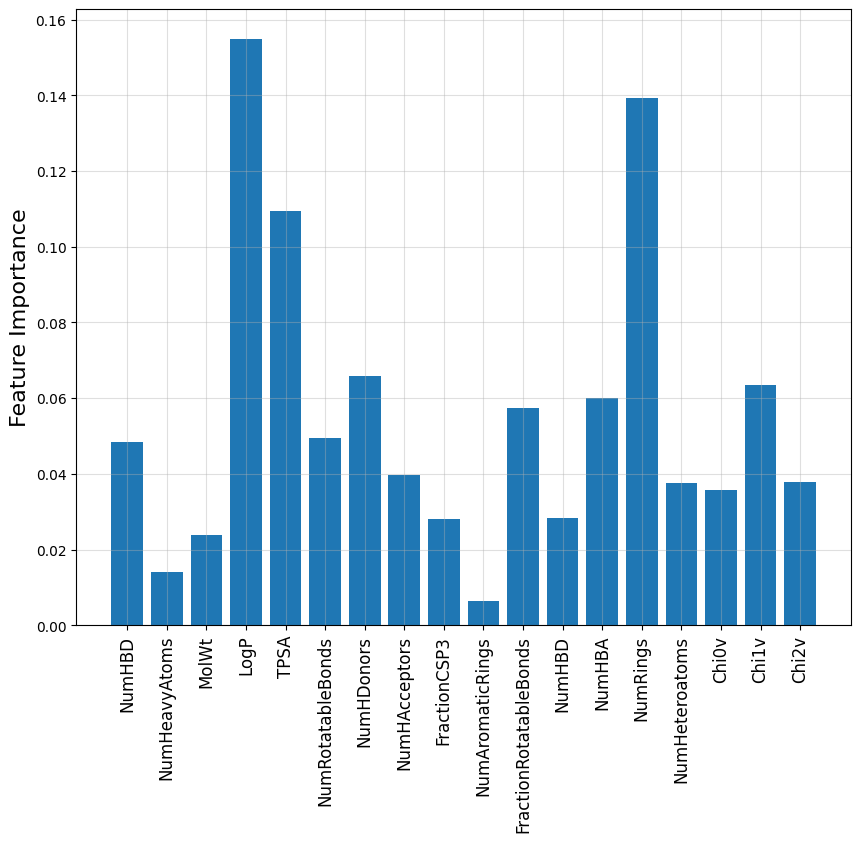

In [196]:
plt.figure(figsize=(10, 8))

plt.bar(range(len(temp_regr_importance)), temp_regr_importance, tick_label=descriptors)

plt.grid(alpha=0.4)
plt.xticks(rotation=90, fontsize=12)  # Rotate labels by 45 degrees
plt.ylabel("Feature Importance", fontsize=16)
